# Bayesian A/B Testing

## ALGO, Jan 2021

by Bartek

## Bayesian A/B Testing: Plan

#### 1. Few comments on Clinical Trials

#### 2. Null Hypothesis Testing

#### 3. Frequentist Example

#### 4. Bayesian Example

* Direct calculation
* Using Metropolis algorithm with `pymc3`

## A/B Testing, Clinical Trials, Randomized Controlled Trials, Hypothesis Testing

<img src="imgs/JamesLind.jpg" align="center">

### James Lind: Scurvy

Lind: Scurvy is due __putrefaction__, thus it can be helped by acids. 

#### Expermients

Lind divided twelve scorbutic sailors into the following six groups of two.
1. Group one: was given a quart of cider daily, 
2. Group two: twenty-five drops of elixir of vitriol (sulfuric acid), 
3. Group three: six spoonfuls of vinegar, 
4. Group four: half a pint of seawater, 
5. Group five: received two oranges and one lemon,
6. Group six: a spicy paste plus a drink of barley water.

In addition, they all received the same diet.

#### Results

The treatment of __group five__ stopped after six days when they ran out of fruit, but by that time one sailor was fit for duty while the other had almost recovered. 

Apart from that, only __group one__ also showed some effect of its treatment.

## Null Hypothesis Testing

<img src="imgs/null_hypothesis.png" align="center">

#### Null Hypothesis Testing (Steps)

* There is an initial research hypothesis of which the truth is unknown.

* State the relevant __null hypotheses__ $H_0$ and __alternative hypotheses__ $H_1$.

* State the __statistical assumptions__ that are made about the sample in doing the test.

* Decide which test is appropriate, and state the relevant __test statistic__.

* Derive the distribution of _T_, the test statistic under the null hypothesis from the assumptions.

* Select a significance level $\alpha$, a probability threshold below which the null hypothesis will be rejected. 

* The distribution of the test statistic under the null hypothesis partitions the possible values of _T_ into those for which the null hypothesis is rejected—the so-called __critical region__—and those for which it is not.

* Compute from the observations the value $t_\textrm{obs}$ of the test statistic _T_.

* Decide to either reject the null hypothesis in favor of the alternative or not reject it. The decision rule is to reject the null hypothesis $H_0$ if the observed value $t_\textrm{obs}$ is in the critical region, and to accept or "fail to reject" the hypothesis otherwise.

### Type I and Type II errors

#### Type I error

The rejection of a true null hypothesis as the result of a test procedure. 

#### Type II error

The failure to reject a false null hypothesis as the result of a test procedure.

<img src="imgs/sn.png" align="center">

## Example: Cookie Cats



<https://www.kaggle.com/yufengsui/mobile-games-ab-testing>


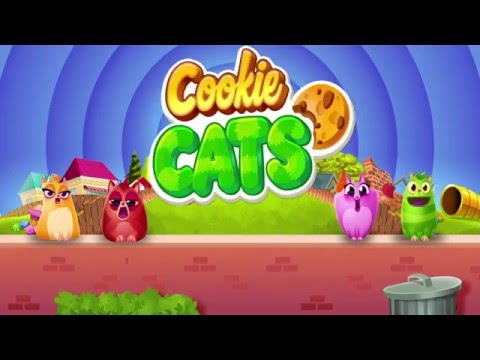

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('GaP5f0jVTWE', width=900, height=600)

### Question: where we should a put gate (blocker)


<img src="imgs/cc_gates.png" align="center">

#### Initial hypothesis

More players come back and play 7 days after installing if the gate is located at level 30?

* Group A: blocker at level 30
* Group B: blocker at leval 40

### Dataset

In [2]:
import pandas as pd

df = pd.read_csv('../data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df_agg = df.groupby('version', as_index=False).agg({
    'userid': 'count', 
    'sum_gamerounds': 'sum', 
    'retention_1': 'sum',
    'retention_7': 'sum'
})
df_agg['avg_gamerounds'] = df_agg['sum_gamerounds'] / df_agg['userid']
df_agg['norm_retention_1'] = df_agg['retention_1'] / df_agg['userid']
df_agg['norm_retention_7'] = df_agg['retention_7'] / df_agg['userid']
df_agg

,version,userid,sum_gamerounds,retention_1,retention_7,avg_gamerounds,norm_retention_1,norm_retention_7
0,gate_30,44700,2344795,20034,8502,52.456264,0.448188,0.190201
1,gate_40,45489,2333530,20119,8279,51.298776,0.442283,0.182000


### Two-proportion z-test

pooled for $H_0\colon p_1=p_2$

$$ z=\frac{(\hat{p}_1 - \hat{p}_2)}{\sqrt{\hat{p}(1 - \hat{p})(\frac{1}{n_1} + \frac{1}{n_2})}}$$

where $\hat{p}=\frac{x_1 + x_2}{n_1 + n_2}$.

In [4]:
import math

def pooled_two_proportions_zscore(size_control, size_treatment, successes_control, successes_treatment):
    p_control, p_treatment = successes_control/size_control, successes_treatment/size_treatment
    
    p_pooled = (successes_control + successes_treatment) / (size_control + size_treatment)
    sd_pooled = math.sqrt(p_pooled * (1-p_pooled))
    se_pooled = sd_pooled * math.sqrt(1/size_control + 1/size_treatment)
    z_score = (p_treatment - p_control) / se_pooled
    return z_score

### p-value

<img src="imgs/sn.png" align="center">

### p-value

In [5]:
from scipy import stats

def p_value(z_score, side=1):
    """
    side: 0  if null hypotesis successes_control == successes_treatment, 
          1  if null hypothesis successes_control >= successes_treatment
          -1 if null hypothesis successes_control <= successes_treatment
    """
    cum_dist = stats.norm.cdf(z_score)
    if side == 1:
        return 1 - cum_dist
    if side == -1:
        return cum_dist
    return 2 * min(1 - cum_dist, cum_dist) 

def get_p_value(size_control, size_treatment, successes_control, successes_treatment, side=0):
    z_score = pooled_two_proportions_zscore(size_control, size_treatment, successes_control, successes_treatment)
    return p_value(z_score, side)

### 7-day retention

In [14]:
# Gate at level 40
size_control = 45489
successes_control = 8279

# Gate at level 30
size_treatment = 44700
successes_treatment = 8502

In [6]:
get_p_value(size_control, size_treatment, successes_control, successes_treatment, side=0)

0.0015542499756142636

## Bayesian approach

<img src="imgs/frequentists_vs_bayesians_2x.png" align="center">

## Bayesian approach (steps)

* There is an initial research hypothesis of which the truth is unknown.

* State the __statistical assumptions__ that are made about the sample in doing the test and the metrics $m_A$ and $m_B$ we compare.

* Derive the distribution of $m_A$ and $m_B$.

* Compute from the observations the probability $\mathrm{Pr}(m_A > m_B)$.

### Example: 7 day retention, which distribution?

$$
x_i | p \sim \mathrm{Bernoulli}(p) \\
p \sim \mathrm{Beta}(\alpha,\beta) 
$$

$
\mathrm{Beta}(\alpha,\beta)(p)
    = \frac{p^{\alpha-1} (1-p)^{\beta-1}}{\mathrm{B}(\alpha,\beta)} \quad \text{for } 0\le p\le 1,
$

where $\mathrm{B}(\alpha,\beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}$

and $\Gamma(x) = \int_0^\infty t^{x-1} e^{-t}\,dt, x > 0$. In particular, $\Gamma(n) = (n-1)!$

## Conjugate prior probability for Bernoulli

The __beta distribution__ is the conjugate prior probability distribution for the Bernoulli, binomial and geometric.


${\rm Pr}(p=x) = {x^{\alpha-1}(1-x)^{\beta-1} \over \mathrm{B}(\alpha,\beta)}$

${\rm Pr}(s, f \mid p=x) = {s+f \choose s} x^s(1-x)^f$

${\rm Pr}(p=x \mid s,f) = \frac{{\rm Pr}(s, f \mid x){\rm Pr}(x)}{\int {\rm Pr}(s, f \mid y){\rm Pr}(y)dy}$

$\,\,\,\,\, = {{{s+f \choose s} x^{s+\alpha-1}(1-x)^{f+\beta-1} / \mathrm{B}(\alpha,\beta)} \over \int_{y=0}^1 \left({s+f \choose s} y^{s+\alpha-1}(1-y)^{f+\beta-1} / \mathrm{B}(\alpha,\beta)\right) dy}$

$\,\,\,\,\, = {x^{s+\alpha-1}(1-x)^{f+\beta-1} \over \mathrm{B}(s+\alpha,f+\beta)}.$

### Posterior betas for the experiment

Let choose the prior distribution for $p_A, p_B \sim {\rm Beta}(1, 1)$ 

Then posterior distributions are:

$ p_A \sim {\rm Beta}(\alpha_A, \beta_A)$, where $\alpha_A = 1 + s_A$ and $\beta_B = 1 + f_A$ 

$ p_B \sim {\rm Beta}(\alpha_B, \beta_B)$, where $\alpha_B = 1 + s_B$ and $\beta_B = 1 + f_B$

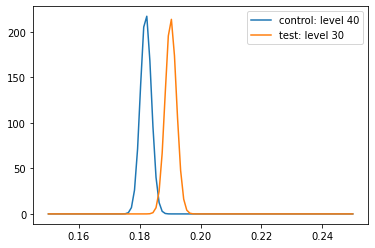

In [7]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

size_control = 45489
size_treatment = 44700
successes_control = 8279 
successes_treatment = 8502

alpha_A = 1 + successes_control
beta_A = 1 + size_control - successes_control
alpha_B = 1 + successes_treatment
beta_B = 1 + size_treatment - successes_treatment

x = np.linspace(0.15, 0.25, 100)
y1 = beta.pdf(x, alpha_A, beta_A)
y2 = beta.pdf(x, alpha_B, beta_B)
plt.plot(x, y1, label = "control: level 40")
plt.plot(x, y2, label = "test: level 30")
plt.legend()
plt.show()

### Probability

$$
{\rm Pr}(p_B > p_A) = \int_0^1 \int_{p_A}^1 \frac{p_A^{\alpha_A-1}(1-p_A)^{\beta_A-1}}{B(\alpha_A, \beta_A)} \frac{{p_B}^{\alpha_B-1}(1-p_B)^{\beta_B-1}}{B(\alpha_B, \beta_B)} dp_B dp_A
$$

$$
{\rm Pr}(p_B > p_A) = 1 - \int_0^1 \frac{p_A^{\alpha_A-1}(1-p_A)^{\beta_A-1}}{B(\alpha_A,\beta_A)}I_{p_A}(\alpha_B, \beta_B)dp_A
$$

where  $I_x$ is the __regularized incomplete beta function__:

$$I_x(a,b) = \frac{\mathrm{B}(x;\,a,b)}{\mathrm{B}(a,b)}$$

where $\mathrm{B}(x;\,a,b) = \int_0^x t^{a-1}\,(1-t)^{b-1}\,dt.$

Using the identity $I_x(1,b) = 1 - (1 - x)^b$, 

the recursive relationship $I_x(a, b) = I_x(a-1, b) - \frac{x^{a-1}(1-x)^b}{(a-1)B(a-1,b)}$

and the fact that $\alpha$ and $\beta$ are integers, we can express $I_x$ as:

$$
I_x(a, b) = 1 - (1 - x)^b - \sum_{j=1}^{a-1}\frac{x^{a-j}(1-x)^b}{(a-j)B(a-j,b)}
$$

Or equivalently

$$
I_x(a, b) = 1 - \sum_{i=0}^{a-1} \frac{x^{i}(1 - x)^b}{(b+i)B(1+i,b)}
$$
   


Then using
$$
{\rm Pr}(p_B > p_A) = 1 - \int_0^1 \frac{p_A^{\alpha_A-1}(1-p_A)^{\beta_A-1}}{B(\alpha_A,\beta_A)}I_{p_A}(\alpha_B, \beta_B)dp_A
$$
and
$$
I_x(a, b) = 1 - \sum_{i=0}^{a-1} \frac{x^{i}(1 - x)^b}{(b+i)B(1+i,b)}
$$
we have
$$
\begin{array}{ll}
{\rm Pr}(p_B > p_A) & =&  1 - \int_0^1 \frac{p_A^{\alpha_A-1}(1-p_A)^{\beta_A-1}}{B(\alpha_A,\beta_A)} \left(1 - \sum_{i=0}^{\alpha_B-1}{\frac{p_A^i(1-p_A)^{\beta_B}}{(\beta_B+i)B(1+i, \beta_B)}}\right)dp_A \\
& =&  1 - 1 + \int_0^1 \frac{p_A^{\alpha_A-1}(1-p_A)^{\beta_A-1}}{B(\alpha_A,\beta_A)} \sum_{i=0}^{\alpha_B-1}{\frac{p_A^i(1-p_A)^{\beta_B}}{(\beta_B+i)B(1+i, \beta_B)}}dp_A \\
& =& \int_0^1 \sum_{i=0}^{\alpha_B-1}{\frac{p_A^{\alpha_A-1+i}(1-p_A)^{\beta_A+\beta_B-1}}{(\beta_B+i)B(\alpha_A, \beta_A)B(1+i, \beta_B)}}dp_A \\
& =& \sum_{i=0}^{\alpha_B-1}\int_0^1{\frac{p_A^{\alpha_A-1+i}(1-p_A)^{\beta_A+\beta_B-1}}{(\beta_B+i)B(\alpha_A, \beta_A)B(1+i, \beta_B)}}dp_A \\
& =& \sum_{i=0}^{\alpha_B-1}\frac{B(\alpha_A+i,\beta_A+\beta_B)}{(\beta_B+i)B(\alpha_A, \beta_A)B(1+i, \beta_B)} \int_0^1{\frac{p_A^{\alpha_A-1+i}(1-p_A)^{\beta_A+\beta_B-1}}{B(\alpha_A+i,\beta_A+\beta_B)}}dp_A 
\end{array}
$$

Finally
$$
{\rm Pr}(p_B > p_A) = \sum_{i=0}^{\alpha_B-1}\frac{B(\alpha_A+i,\beta_A+\beta_B)}{(\beta_B+i) 
B(1+i, \beta_B)
B(\alpha_A, \beta_A)
}
$$

In [8]:
import scipy.special as sc
import numpy as np

def probability_B_beats_A(alpha_A, beta_A, alpha_B, beta_B):
    total = 0.
    for i in range(alpha_B):
        total += np.exp(sc.betaln(alpha_A+i, beta_B+beta_A) - 
                        np.log(beta_B+i) - sc.betaln(1+i, beta_B) - sc.betaln(alpha_A, beta_A))
    return total

In [9]:
size_control = 45489
size_treatment = 44700
successes_control = 8279 
successes_treatment = 8502

alpha_A = successes_control
beta_A = size_control - successes_control
alpha_B = successes_treatment
beta_B = size_treatment - successes_treatment

probability_B_beats_A(alpha_A, beta_A, alpha_B, beta_B)

0.9992228415122071

### Metropolis algoriths

$$
x_i | p \sim \mathrm{Bernoulli}(p) \\
p \sim \mathrm{Beta}(\alpha,\beta) 
$$

In [20]:
import pymc3 as pm
dfA = df.query("version == 'gate_30'")
dfB = df.query("version == 'gate_40'")
colname = 'retention_7'

with pm.Model() as model:
    p_A = pm.Beta("p_A", 1, 1) 
    p_B = pm.Beta("p_B", 1, 1)
    
    delta = pm.Deterministic("delta", p_A - p_B)
    obs_A = pm.Bernoulli("obs_A", p_A, observed=dfA[colname].values.astype(int))
    obs_B = pm.Bernoulli("obs_B", p_B, observed=dfB[colname].values.astype(int))

    
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[1000:] 

/Users/bartekskorulski/.virtualenvs/bayesian-abtesting-3.9.1/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 39 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [12]:
p_A_samples = burned_trace["p_A"] 
p_B_samples = burned_trace["p_B"] 
delta_samples = burned_trace["delta"] 

In [13]:
np.mean(delta_samples > 0)

0.9995263157894737

## We are hiring

## https://koahealth.com/contact#work-with-us
